C:\Users\pbenko\AppData\Local\Temp\1\ipykernel_17836\1515134158.py:22: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



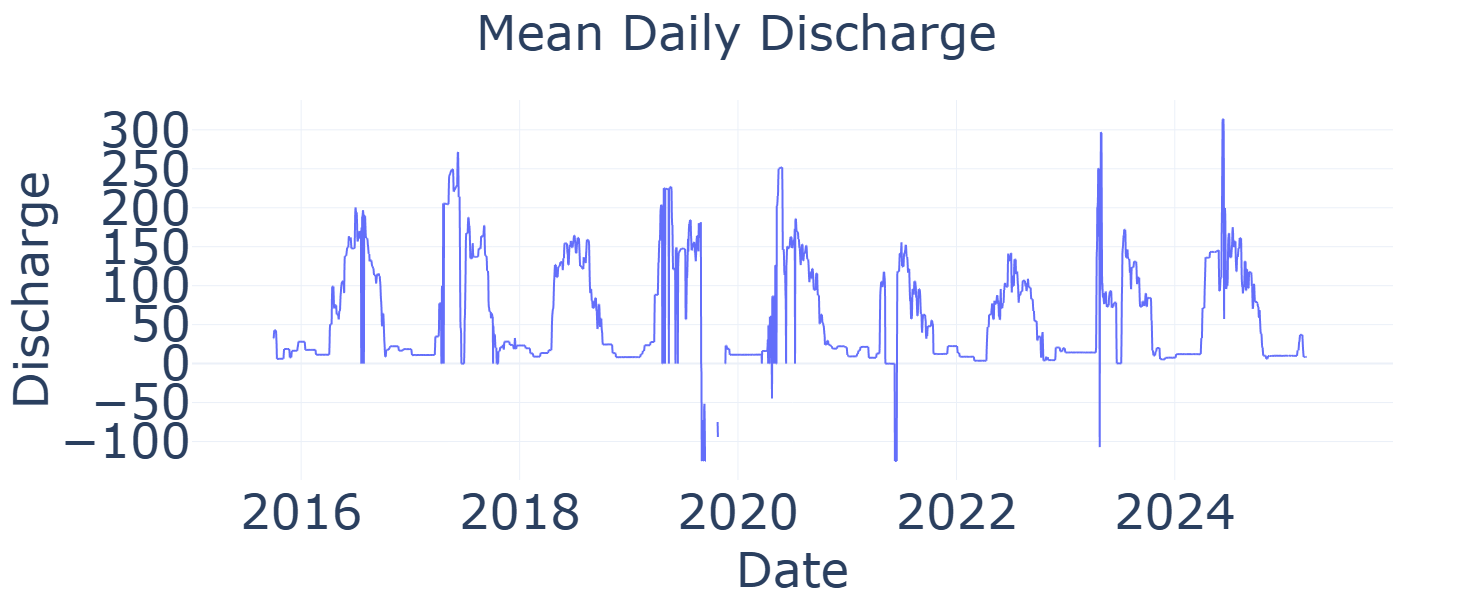

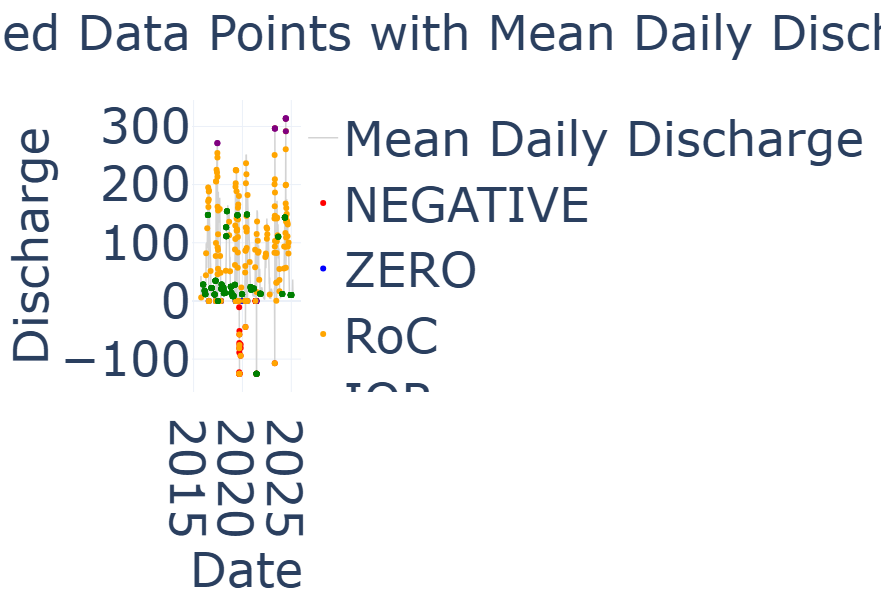

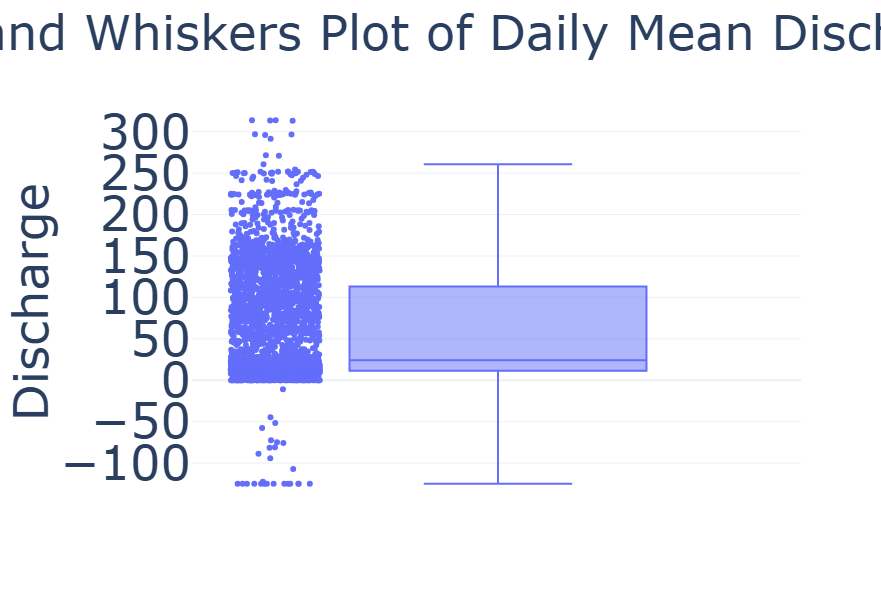

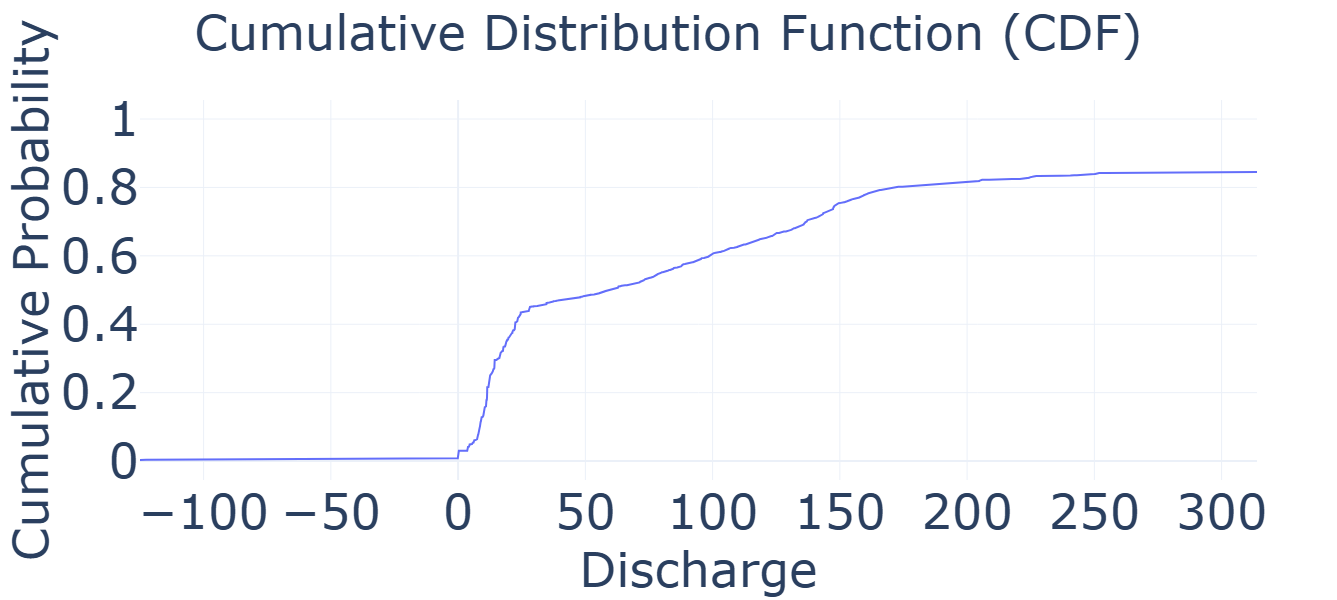

In [10]:
import pyodbc
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go

# Database connection parameters
server = 'wrt-sql-prod'
database = 'dvrtDB'
username = 'wrtsqlq'
password = 'guest'

# Establish connection and fetch data
with pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password}"
) as conn:
    query = "SELECT * FROM dbo.DAILY_RECORDS WHERE STATION_ID = 10987"
    df = pd.read_sql_query(query, conn)

# Reshape data: Convert wide format (RV_0101 to RV_1231) into long format
df_melted = df.melt(id_vars=['STATION_ID', 'RECORD_YEAR'], 
                     var_name='DAY', 
                     value_name='DISCHARGE')

# Extract and clean the DAY column (remove "RV_" and ensure 4-digit format)
df_melted['DAY'] = df_melted['DAY'].str[3:].str.zfill(4)

# Combine YEAR and DAY into a proper DATE column and handle invalid dates
df_melted['DATE'] = pd.to_datetime(
    df_melted['RECORD_YEAR'].astype(str) + df_melted['DAY'], 
    format='%Y%m%d', 
    errors='coerce'
)

# Drop rows where DATE is NaT (invalid dates or NULL values)
df_melted = df_melted.dropna(subset=['DATE'])

# Keep only relevant columns and sort
df_melted = df_melted[['DATE', 'DISCHARGE']].sort_values(by='DATE')

# === FLAGGING CRITERIA === #
df_melted['FLAG_NEGATIVE'] = df_melted['DISCHARGE'] < 0
df_melted['FLAG_ZERO'] = df_melted['DISCHARGE'] == 0

# Calculate Rate of Change (RoC)
df_melted['RoC'] = df_melted['DISCHARGE'].diff().abs()

# Flagging based on 95th percentile of Rate of Change
roc_threshold = df_melted['RoC'].quantile(0.95)
df_melted['FLAG_RoC'] = df_melted['RoC'] > roc_threshold

# IQR Outlier Detection
Q1 = df_melted['DISCHARGE'].quantile(0.25)
Q3 = df_melted['DISCHARGE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_melted['FLAG_IQR'] = (df_melted['DISCHARGE'] < lower_bound) | (df_melted['DISCHARGE'] > upper_bound)

# Flag repeated values for more than 3 consecutive days
df_melted['FLAG_REPEATED'] = (df_melted['DISCHARGE']
                              .groupby((df_melted['DISCHARGE'] != df_melted['DISCHARGE'].shift()).cumsum())
                              .transform('count') >= 4)

# Combine all flag conditions
df_melted['FLAGGED'] = df_melted[['FLAG_NEGATIVE', 'FLAG_ZERO', 'FLAG_RoC', 'FLAG_IQR', 'FLAG_REPEATED']].any(axis=1)

# === INTERACTIVE PLOTS === #
font_settings = dict(size=48)  # Triple the font size (default ~16)

# 1️⃣ **Original plot (Mean Daily Discharge)**
fig1 = px.line(
    df_melted, x='DATE', y='DISCHARGE', 
    title='Mean Daily Discharge',
    template='plotly_white',
    width=1200, height=600
)
fig1.update_layout(
    title=dict(x=0.5, font=font_settings),
    xaxis=dict(title='Date', titlefont=font_settings, tickfont=font_settings),
    yaxis=dict(title='Discharge', titlefont=font_settings, tickfont=font_settings)
)
fig1.show()

# 2️⃣ **Flagged data points overlaid on Mean Daily Discharge**
df_flagged = df_melted[df_melted['FLAGGED']]

fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=df_melted['DATE'], y=df_melted['DISCHARGE'],
    mode='lines',
    line=dict(color='lightgray', width=1.5),
    name='Mean Daily Discharge'
))

flag_colors = {
    'FLAG_NEGATIVE': 'red',
    'FLAG_ZERO': 'blue',
    'FLAG_RoC': 'orange',
    'FLAG_IQR': 'purple',
    'FLAG_REPEATED': 'green'
}

for flag, color in flag_colors.items():
    subset = df_flagged[df_flagged[flag]]
    fig2.add_trace(go.Scatter(
        x=subset['DATE'], y=subset['DISCHARGE'],
        mode='markers',
        marker=dict(color=color, size=6),
        name=flag.replace('FLAG_', '').replace('_', ' ')
    ))

fig2.update_layout(
    title=dict(text='Flagged Data Points with Mean Daily Discharge', x=0.5, font=font_settings),
    xaxis=dict(title='Date', titlefont=font_settings, tickfont=font_settings),
    yaxis=dict(title='Discharge', titlefont=font_settings, tickfont=font_settings),
    legend=dict(font=font_settings),
    template='plotly_white',
    width=1200, height=600
)
fig2.show()

# 3️⃣ **Interactive Box and Whiskers Plot**
fig3 = px.box(
    df_melted, y='DISCHARGE', 
    title='Box and Whiskers Plot of Daily Mean Discharge',
    template='plotly_white',
    points="all",
    width=900, height=600
)
fig3.update_layout(
    title=dict(x=0.5, font=font_settings),
    yaxis=dict(title='Discharge', titlefont=font_settings, tickfont=font_settings),
    xaxis=dict(title='', tickfont=font_settings)
)
fig3.show()

# 4️⃣ **Cumulative Distribution Function (CDF) Plot**
df_melted_sorted = df_melted.sort_values(by='DISCHARGE')
df_melted_sorted['CDF'] = np.arange(1, len(df_melted_sorted) + 1) / len(df_melted_sorted)

fig4 = go.Figure()
fig4.add_trace(go.Scatter(
    x=df_melted_sorted['DISCHARGE'], y=df_melted_sorted['CDF'],
    mode='lines',
    name='CDF'
))
fig4.update_layout(
    title=dict(text='Cumulative Distribution Function (CDF)', x=0.5, font=font_settings),
    xaxis=dict(title='Discharge', titlefont=font_settings, tickfont=font_settings),
    yaxis=dict(title='Cumulative Probability', titlefont=font_settings, tickfont=font_settings),
    template='plotly_white',
    width=900, height=600
)
fig4.show()

In [3]:
import pyodbc
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go

# Database connection parameters
server = 'wrt-sql-prod'
database = 'dvrtDB'
username = 'wrtsqlq'
password = 'guest'

# Establish connection and fetch data
with pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password}"
) as conn:
    query = "SELECT * FROM dbo.DAILY_RECORDS WHERE STATION_ID = 10987"
    df = pd.read_sql_query(query, conn)

# Reshape data: Convert wide format (RV_0101 to RV_1231) into long format
df_melted = df.melt(id_vars=['STATION_ID', 'RECORD_YEAR'], 
                     var_name='DAY', 
                     value_name='DISCHARGE')

# Extract and clean the DAY column (remove "RV_" and ensure 4-digit format)
df_melted['DAY'] = df_melted['DAY'].str[3:].str.zfill(4)

# Combine YEAR and DAY into a proper DATE column and handle invalid dates
df_melted['DATE'] = pd.to_datetime(
    df_melted['RECORD_YEAR'].astype(str) + df_melted['DAY'], 
    format='%Y%m%d', 
    errors='coerce'
)

# Drop rows where DATE is NaT (invalid dates or NULL values)
df_melted = df_melted.dropna(subset=['DATE'])

# Keep only relevant columns and sort
df_melted = df_melted[['DATE', 'DISCHARGE']].sort_values(by='DATE')

# === FLAGGING CRITERIA === #
df_melted['FLAG_NEGATIVE'] = df_melted['DISCHARGE'] < 0
df_melted['FLAG_ZERO'] = df_melted['DISCHARGE'] == 0

# Calculate Rate of Change (RoC)
df_melted['RoC'] = df_melted['DISCHARGE'].diff().abs()

# Flagging based on 95th percentile of Rate of Change
roc_threshold = df_melted['RoC'].quantile(0.95)
df_melted['FLAG_RoC'] = df_melted['RoC'] > roc_threshold

# IQR Outlier Detection
Q1 = df_melted['DISCHARGE'].quantile(0.25)
Q3 = df_melted['DISCHARGE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_melted['FLAG_IQR'] = (df_melted['DISCHARGE'] < lower_bound) | (df_melted['DISCHARGE'] > upper_bound)

# Flag repeated values for more than 3 consecutive days
df_melted['FLAG_REPEATED'] = (df_melted['DISCHARGE']
                              .groupby((df_melted['DISCHARGE'] != df_melted['DISCHARGE'].shift()).cumsum())  # Identify runs of same values
                              .transform('count') >= 4)  # Flag only if the count in a run is 4 or more

# Combine all flag conditions
df_melted['FLAGGED'] = df_melted[['FLAG_NEGATIVE', 'FLAG_ZERO', 'FLAG_RoC', 'FLAG_IQR', 'FLAG_REPEATED']].any(axis=1)

# === INTERACTIVE PLOTS === #

# 1️⃣ **Original plot (Mean Daily Discharge)**
fig1 = px.line(
    df_melted, x='DATE', y='DISCHARGE', 
    title='Mean Daily Discharge',
    template='plotly_white',
    width=1200, height=600
)
fig1.show()

# 2️⃣ **Flagged data points overlaid on Mean Daily Discharge**
df_flagged = df_melted[df_melted['FLAGGED']]

fig2 = go.Figure()

# Add original discharge data as a **faint background line**
fig2.add_trace(go.Scatter(
    x=df_melted['DATE'], y=df_melted['DISCHARGE'],
    mode='lines',
    line=dict(color='lightgray', width=1.5),
    name='Mean Daily Discharge'
))

# Add flagged points **colored by condition**
flag_colors = {
    'FLAG_NEGATIVE': 'red',
    'FLAG_ZERO': 'blue',
    'FLAG_RoC': 'orange',
    'FLAG_IQR': 'purple',
    'FLAG_REPEATED': 'green'
}

for flag, color in flag_colors.items():
    subset = df_flagged[df_flagged[flag]]
    fig2.add_trace(go.Scatter(
        x=subset['DATE'], y=subset['DISCHARGE'],
        mode='markers',
        marker=dict(color=color, size=6),
        name=flag.replace('FLAG_', '').replace('_', ' ')  # Clean legend labels
    ))

fig2.update_layout(
    title="Flagged Data Points with Mean Daily Discharge",
    xaxis_title="Date",
    yaxis_title="Discharge",
    template="plotly_white",
    width=1200, height=600
)

fig2.show()

# 3️⃣ **Interactive Box and Whiskers Plot (Box Plot for Discharge Data)**
fig3 = px.box(
    df_melted, y='DISCHARGE', 
    title='Box and Whiskers Plot of Daily Mean Discharge',
    template='plotly_white',
    points="all",  # Show all data points as outliers
    width=900, height=600
)
fig3.show()

# 4️⃣ **Cumulative Distribution Function (CDF) Plot**
# Sort the discharge data and calculate the cumulative probability
df_melted_sorted = df_melted.sort_values(by='DISCHARGE')
df_melted_sorted['CDF'] = np.arange(1, len(df_melted_sorted) + 1) / len(df_melted_sorted)

# Calculate statistics
min_val = df_melted_sorted['DISCHARGE'].min()
max_val = df_melted_sorted['DISCHARGE'].max()
median_val = df_melted_sorted['DISCHARGE'].median()
q1_val = Q1
q3_val = Q3
percentile_95 = np.percentile(df_melted_sorted['DISCHARGE'], 95)

# Create CDF plot
fig4 = go.Figure()

# Plot CDF
fig4.add_trace(go.Scatter(
    x=df_melted_sorted['DISCHARGE'], y=df_melted_sorted['CDF'],
    mode='lines',
    line=dict(color='blue', width=2),
    name='CDF of Discharge'
))

# Add vertical lines for each statistic
fig4.add_trace(go.Scatter(
    x=[min_val, min_val], y=[0, 1],
    mode='lines', line=dict(color='green', dash='dash'),
    name='Minimum'
))

fig4.add_trace(go.Scatter(
    x=[max_val, max_val], y=[0, 1],
    mode='lines', line=dict(color='red', dash='dash'),
    name='Maximum'
))

fig4.add_trace(go.Scatter(
    x=[median_val, median_val], y=[0, 1],
    mode='lines', line=dict(color='purple', dash='dash'),
    name='Median'
))

fig4.add_trace(go.Scatter(
    x=[q1_val, q1_val], y=[0, 1],
    mode='lines', line=dict(color='orange', dash='dash'),
    name='Q1'
))

fig4.add_trace(go.Scatter(
    x=[q3_val, q3_val], y=[0, 1],
    mode='lines', line=dict(color='yellow', dash='dash'),
    name='Q3'
))

fig4.add_trace(go.Scatter(
    x=[percentile_95, percentile_95], y=[0, 1],
    mode='lines', line=dict(color='brown', dash='dash'),
    name='95th Percentile'
))

fig4.update_layout(
    title="Cumulative Distribution Function (CDF) of Discharge with Statistical Markers",
    xaxis_title="Discharge",
    yaxis_title="Cumulative Probability",
    template="plotly_white",
    width=900, height=600
)

fig4.show()

# 5️⃣ **CDF Plot for Data Points that Meet RoC Criteria**
# Filter the data points that meet the RoC threshold
df_roc = df_melted[df_melted['FLAG_RoC']]

# Sort the filtered data and calculate the cumulative probability
df_roc_sorted = df_roc.sort_values(by='DISCHARGE')
df_roc_sorted['CDF'] = np.arange(1, len(df_roc_sorted) + 1) / len(df_roc_sorted)

# Create CDF plot for data points that meet the RoC criteria
fig5 = go.Figure()

# Plot CDF for RoC data
fig5.add_trace(go.Scatter(
    x=df_roc_sorted['DISCHARGE'], y=df_roc_sorted['CDF'],
    mode='lines',
    line=dict(color='purple', width=2),
    name='CDF of Discharge (RoC Criteria)'
))

# Add vertical lines for each statistic (same as before)
fig5.add_trace(go.Scatter(
    x=[min_val, min_val], y=[0, 1],
    mode='lines', line=dict(color='green', dash='dash'),
    name='Minimum'
))

fig5.add_trace(go.Scatter(
    x=[max_val, max_val], y=[0, 1],
    mode='lines', line=dict(color='red', dash='dash'),
    name='Maximum'
))

fig5.add_trace(go.Scatter(
    x=[median_val, median_val], y=[0, 1],
    mode='lines', line=dict(color='purple', dash='dash'),
    name='Median'
))

fig5.add_trace(go.Scatter(
    x=[q1_val, q1_val], y=[0, 1],
    mode='lines', line=dict(color='orange', dash='dash'),
    name='Q1'
))

fig5.add_trace(go.Scatter(
    x=[q3_val, q3_val], y=[0, 1],
    mode='lines', line=dict(color='yellow', dash='dash'),
    name='Q3'
))

fig5.add_trace(go.Scatter(
    x=[percentile_95, percentile_95], y=[0, 1],
    mode='lines', line=dict(color='brown', dash='dash'),
    name='95th Percentile'
))

fig5.update_layout(
    title="Cumulative Distribution Function (CDF) for Data Points Meeting RoC Criteria",
    xaxis_title="Discharge",
    yaxis_title="Cumulative Probability",
    template="plotly_white",
    width=900, height=600
)

fig5.show()

# Calculate Rate of Change (RoC) as done previously
roc_threshold = df_melted['RoC'].quantile(0.95)
min_roc = -roc_threshold
max_roc = roc_threshold

# Calculate summary statistics for RoC
roc_min = df_melted['RoC'].min()
roc_max = df_melted['RoC'].max()
roc_median = df_melted['RoC'].median()
roc_95th = df_melted['RoC'].quantile(0.95)

# === RoC Distribution Plot === #
fig6 = go.Figure()

# Add a Histogram of RoC values with interactivity
fig6.add_trace(go.Histogram(
    x=df_melted['RoC'], 
    nbinsx=50,  # Number of bins
    histnorm='percent',  # Normalize to percentage
    name='Rate of Change Distribution',
    marker=dict(color='lightblue'),
    hoverinfo='x+y',  # Show both x and y values on hover
    hoverlabel=dict(bgcolor='white', font_size=12)  # Customize hover label appearance
))

# Add vertical lines for the 95th percentile range (-17.33 to 17.33)
#fig6.add_trace(go.Scatter(
    x=[min_roc, min_roc], y=[0, 100],
    mode='lines', line=dict(color='red', dash='dash'),
    name=f"Min RoC Threshold ({min_roc})"
))

#fig6.add_trace(go.Scatter(
    x=[max_roc, max_roc], y=[0, 100],
    mode='lines', line=dict(color='red', dash='dash'),
    name=f"Max RoC Threshold ({max_roc})"
))

# Add a vertical line for the median RoC
#fig6.add_trace(go.Scatter(
    x=[roc_median, roc_median], y=[0, 100],
    mode='lines', line=dict(color='green', dash='dash'),
    name=f"Median RoC ({roc_median})"
))

# Add title and labels
#fig6.update_layout(
    title="Rate of Change Distribution with 95th Percentile Thresholds",
    xaxis_title="Rate of Change",
    yaxis_title="Percentage (%)",
    template="plotly_white",
    width=1200, height=600,
    hovermode='closest',  # Interactive hover behavior
    showlegend=True  # Show the legend for the different thresholds
)

# Show the interactive Histogram Plot with the Summary Table
fig6.show()

# Define the number of bins for the histogram
nbinsx = 50

# Calculate Rate of Change (RoC)
roc_threshold = df_melted['RoC'].quantile(0.95)
min_roc = -roc_threshold
max_roc = roc_threshold

# Remove NaN values from RoC column before performing the histogram
df_melted_cleaned = df_melted.dropna(subset=['RoC'])

# Use numpy's histogram function to get the bin edges and the counts of data points in each bin
counts, bin_edges = np.histogram(df_melted_cleaned['RoC'], bins=nbinsx)

# === Create DataFrame for the Histogram Data === #
# Prepare a DataFrame to show the bin ranges and counts of data points
hist_df = pd.DataFrame({
    'Bin Start': bin_edges[:-1],  # Exclude the last edge to align with the count data
    'Bin End': bin_edges[1:],  # The end of each bin is the next edge
    'Count': counts  # The count of data points in each bin
})

# Print the summary table
print(hist_df)

# Optionally, export this data to CSV
hist_df.to_csv('roc_distribution_histogram_counts.csv', index=False)

IndentationError: unexpected indent (441451518.py, line 299)